**Installing Libraries**

In [1]:
!pip install torch torchvision torchaudio torchtext

In [2]:
!pip install pytorch-forecasting
!pip install opencv-python

In [3]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install xlwt torchsummary torchvision

Note: you may need to restart the kernel to use updated packages.


**Importing Libraries**

In [5]:
import torch
from torch.utils.data import DataLoader, Dataset

from torch import nn
from torch import optim
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
import torchvision
from torchvision import transforms, utils

import cv2
import random
import math
import scipy.io
import os
from PIL import Image

**Operators.py**

In [6]:
from copy import deepcopy

def crossover(x, y):
    x = deepcopy(x)
    y = deepcopy(y)

    '''First parent'''
    x_nconv = x.n_conv
    x_nfull = x.n_full
    xblocks = x.first_level
    xbinary = x.second_level

    '''Second parent'''
    y_nconv = y.n_conv
    y_nfull = y.n_full
    yblocks = y.first_level
    ybinary = y.second_level

    '''Convolutional part crossover'''
    if x_nconv > y_nconv:
        k = math.floor(y_nconv/2)
        index = list(range(x_nconv))

        '''Exchanging the last k blocks of the smaller parent'''
        for i in range(k, y_nconv):
            block = yblocks[i] #ith block
            ix = random.choice(index) #Selecting random index from larger parent
            index.remove(ix)

            #Exchange of blocks
            yblocks[i] = xblocks[ix]
            xblocks[ix] = block

    if y_nconv > x_nconv:
        k = math.floor(x_nconv/2)
        index = list(range(y_nconv))

        '''Exchanging the last k blocks of the smaller parent'''
        for i in range(k, x_nconv):
            block = xblocks[i] #ith block
            ix = random.choice(index) #Selecting random index from larger parent
            index.remove(ix)

            #Exchange of blocks
            xblocks[i] = yblocks[ix]
            yblocks[ix] = block

    if x_nconv == y_nconv:
        k = math.floor(x_nconv/2)
        index = list(range(x_nconv))

        x_part = xblocks[k:x_nconv]

        '''Exchaning last half of the blocks'''
        xblocks[k:x_nconv] = yblocks[k:y_nconv]
        yblocks[k:y_nconv] = x_part

    '''Fully-connected part'''
    if x_nfull > y_nfull:
        k = math.floor(y_nfull/2)
        index = list(range(x_nconv, x_nconv + x_nfull))

        '''Exchanging the last k blocks of the smaller parent'''
        for i in range(y_nconv + k, y_nconv + y_nfull):
            block = yblocks[i] #ith block
            ix = random.choice(index) #Selecting random index from larger parent
            index.remove(ix)

            #Exchange of blocks
            yblocks[i] = xblocks[ix]
            xblocks[ix] = block

    if y_nfull > x_nfull:
        k = math.floor(x_nfull/2)
        index = list(range(y_nconv, y_nconv + y_nfull))

        '''Exchanging the last k blocks of the smaller parent'''
        for i in range(x_nconv + k, x_nconv + x_nfull):
            block = xblocks[i] #ith block
            ix = random.choice(index) #Selecting random index from larger parent
            index.remove(ix)

            #Exchange of blocks
            xblocks[i] = yblocks[ix]
            yblocks[ix] = block

    if x_nfull == y_nfull:
        k = math.floor(x_nfull/2)

        x_part = xblocks[x_nconv + k:x_nconv + x_nfull]
        '''Exchaning last half of the blocks'''
        xblocks[x_nconv + k:x_nconv + x_nfull] = yblocks[y_nconv + k:y_nconv + y_nfull]
        yblocks[y_nconv + k:y_nconv + y_nfull] = x_part

    '''Second level'''
    if len(xbinary) > len(ybinary):
        if len(ybinary) > 1 :
            k = random.choice(list(range(1, len(ybinary))))
            partition = ybinary[k:]
            nbits = len(partition)

            if random.uniform(0,1) >= 0.5:
                ybinary[k:] = xbinary[len(xbinary) - nbits:len(xbinary)]
                xbinary[len(xbinary) - nbits:len(xbinary)] = partition
            else:
                ybinary[k:] = xbinary[:nbits]
                xbinary[:nbits] = partition

    if len(ybinary) > len(xbinary):
        if len(xbinary) > 1 :
            k = random.choice(list(range(len(xbinary))))
            partition = xbinary[k:]
            nbits = len(partition)

            if random.uniform(0,1) >= 0.5:
                xbinary[k:] = ybinary[len(ybinary) - nbits:len(ybinary)]
                ybinary[len(ybinary) - nbits:len(ybinary)] = partition
            else:
                xbinary[k:] = ybinary[:nbits]
                ybinary[:nbits] = partition

    if len(xbinary) == len(ybinary):
        if len(xbinary) > 1 :
            k = random.choice(list(range(len(xbinary))))
            partition = xbinary[k:]

            xbinary[k:] = ybinary[k:]
            ybinary[k:] = partition

    return x, y

def mutation(x):
    if random.uniform(0,1) < 0.5:
        '''Adding a new block'''
        if random.uniform(0,1) > 0.5:
            #Adding a fully-connected block
            layer = {'type' : 'fc',
                     'neurons' : random.choice(NEURONS)}

            #Choosing a random index to insert the new block
            index = list(range(x.n_conv, x.n_conv + x.n_full))
            ix = random.choice(index)

            x.first_level.insert(ix, layer)
            x.n_full += 1

        else:
            #Adding a convolutional block
            layer = {'type' : 'conv',
                     'nfilters' : random.choice(NFILTERS),
                     'fsize' : random.choice(FSIZES),
                     'pool' : random.choice(['max', 'avg', 'off']),
                     'psize' : random.choice(PSIZES)
                    }
            #Choosing a random index to insert the new block
            index = list(range(x.n_conv))
            ix = random.choice(index)

            x.first_level.insert(ix, layer)
            x.n_conv += 1

            if ix > 1:
                new_bits = []
                for i in range(ix - 1):
                    new_bits.append(random.choice([0,1]))
                pos = int(0.5*(ix**2) - 1.5*(ix) + 1)
                start = pos + len(new_bits)
                for bit in new_bits:
                    x.second_level.insert(pos, bit)
                    pos += 1

                rest = x.n_conv - ix - 1
                add = ix
                for j in range(rest):
                    x.second_level.insert(start+add-1, random.choice([0,1]))
                    start += add
                    ix += 1

            if ix == 0 or ix == 1:
                if x.n_conv - 1 == 2:
                    x.second_level.append(random.choice([0,1]))
                else:
                    add = 0
                    for i in range(2, x.n_conv):
                        pos = int(0.5*(ix**2) - 1.5*(ix) + 1) + add
                        x.second_level.insert(pos, random.choice([0,1]))
                        add += 1

    else:
        '''Changing hyperparameters in one block'''
        if random.uniform(0,1) > 0.5:
            '''Re-starting a fully-connected block'''
            index = list(range(x.n_conv, x.n_conv + x.n_full))
            ix = random.choice(index)
            new_layer = {'type' : 'fc',
                         'neurons' : random.choice(NEURONS)}
            #Switching fully-connected block
            x.first_level[ix] = new_layer

        else:
            '''Re-starting a convolutional block'''
            index = list(range(x.n_conv))
            ix = random.choice(index)
            new_layer = {'type' : 'conv',
                     'nfilters' : random.choice(NFILTERS),
                     'fsize' : random.choice(FSIZES),
                     'pool' : random.choice(['max', 'avg', 'off']),
                     'psize' : random.choice(PSIZES)
                    }

            #Switching convolutional block
            x.first_level[ix] = new_layer

        '''Modifying connections in second level'''
        if len(x.second_level) > 0:
            k = random.choice(list(range(len(x.second_level))))
            #Flipping one bit in the second level
            if x.second_level[k] == 1:
                x.second_level[k] = 0
            else:
                x.second_level[k] = 1


def selection(tournament, style):
    '''Stochastic tournament selection'''
    if style == 'max':
        if random.uniform(0,1) <= 0.8:
            p = max(tournament, key = lambda x: x[1])
        else:
            p = random.choice(tournament)
    else:
        if random.uniform(0,1) <= 0.8:
            p = min(tournament, key = lambda x: x[1])
        else:
            p = random.choice(tournament)

    return p

**EncodingClass.py**

In [7]:
'''Hyperparameters configuration'''
#Convolutional layers
'''Hyperparameters configuration'''
#Convolutional layers
FSIZES = [2,3,4,5,6]
#FSIZES = [2,3,4,5,6,7,8]
NFILTERS = [2,4,8,16,32]

#Pooling layers
PSIZES = [2,3,4,5]
PTYPE = ['max', 'avg']

#Fully connected layers
NEURONS = [4,8,16,32,64,128]

class Encoding:
    def __init__(self, minC, maxC, minF, maxF):
        self.n_conv = random.randint(minC, maxC)
        self.n_full = random.randint(minF, maxF)


        '''First level encoding'''
        self.first_level = []

        #Feature extraction part
        for i in range(self.n_conv):
            layer = {'type' : 'conv',
                     'nfilters' : random.choice(NFILTERS),
                     'fsize' : random.choice(FSIZES),
                     'pool' : random.choice(['max', 'avg', 'off']),
                     'psize' : random.choice(PSIZES)
                    }
            self.first_level.append(layer)

        #Fully connected part
        for i in range(self.n_full):
            layer = {'type' : 'fc',
                     'neurons' : random.choice(NEURONS)}

            self.first_level.append(layer)


        '''Second level encoding'''
        self.second_level = []
        prev = -1
        for i in range(self.n_conv):
            if prev < 1:
                prev += 1
            if prev >= 1:
                for _ in range(prev-1):
                    self.second_level.append(random.choice([0,1]))
                prev += 1

**Decondig.py**

In [8]:
def conv_out_size(W, K):
    return W - K + 3

def pool_out_size(W, K):
    return math.floor((W - K)/2) + 1

In [9]:
def decoding(encoding):
  n_conv = encoding.n_conv
  n_full = encoding.n_full
  first_level = encoding.first_level
  second_level = encoding.second_level

  features = []
  classifier = []
  in_channels = 1
  out_size = 92
  prev = -1
  pos = 0
  o_sizes = []
  for i in range(n_conv):
    layer = first_level[i]
    n_filters = layer['nfilters']
    f_size = layer['fsize']
    pad = 1
    if f_size > out_size:
        f_size = out_size - 1
    if i == 0 or i == 1:
      if layer['pool'] == 'off':
        operation = [nn.Conv2d(in_channels = in_channels, out_channels = n_filters, kernel_size = f_size, padding = pad),
                    nn.BatchNorm2d(n_filters),
                    nn.ReLU(inplace = True)]
        in_channels = n_filters
        out_size = conv_out_size(out_size, f_size)
        o_sizes.append([out_size, in_channels])

      if layer['pool'] == 'avg':
          p_size = layer['psize']
          if p_size > out_size:
              p_size = out_size - 1
          operation = [nn.Conv2d(in_channels = in_channels, out_channels = n_filters, kernel_size = f_size, padding = pad),
                      nn.BatchNorm2d(n_filters),
                      nn.ReLU(inplace = True),
                      nn.AvgPool2d(kernel_size = p_size, stride = 2)]
          in_channels = n_filters
          out_size = conv_out_size(out_size, f_size)
          out_size = pool_out_size(out_size, p_size)
          o_sizes.append([out_size, in_channels])

      if layer['pool'] == 'max':
          p_size = layer['psize']
          if p_size > out_size:
              p_size = out_size - 1
          operation = [nn.Conv2d(in_channels = in_channels, out_channels = n_filters, kernel_size = f_size, padding = pad),
                      nn.BatchNorm2d(n_filters),
                      nn.ReLU(inplace = True),
                      nn.MaxPool2d(kernel_size = p_size, stride = 2)]
          in_channels = n_filters
          out_size = conv_out_size(out_size, f_size)
          out_size = pool_out_size(out_size, p_size)
          o_sizes.append([out_size, in_channels])
    else:
      connections = second_level[pos:pos+prev]
      for c in range(len(connections)):
        if connections[c] == 1:
          in_channels += o_sizes[c][1]

      if layer['pool'] == 'off':
        operation = [nn.Conv2d(in_channels = in_channels, out_channels = n_filters, kernel_size = f_size, padding = pad),
                    nn.BatchNorm2d(n_filters),
                    nn.ReLU(inplace = True)]
        in_channels = n_filters
        out_size = conv_out_size(out_size, f_size)
        o_sizes.append([out_size, in_channels])

      if layer['pool'] == 'avg':
          p_size = layer['psize']
          if p_size > out_size:
              p_size = out_size - 1
          operation = [nn.Conv2d(in_channels = in_channels, out_channels = n_filters, kernel_size = f_size, padding = pad),
                      nn.BatchNorm2d(n_filters),
                      nn.ReLU(inplace = True),
                      nn.AvgPool2d(kernel_size = p_size, stride = 2)]
          in_channels = n_filters
          out_size = conv_out_size(out_size, f_size)
          out_size = pool_out_size(out_size, p_size)
          o_sizes.append([out_size, in_channels])

      if layer['pool'] == 'max':
          p_size = layer['psize']
          if p_size > out_size:
              p_size = out_size - 1
          operation = [nn.Conv2d(in_channels = in_channels, out_channels = n_filters, kernel_size = f_size, padding = pad),
                      nn.BatchNorm2d(n_filters),
                      nn.ReLU(inplace = True),
                      nn.MaxPool2d(kernel_size = p_size, stride = 2)]
          in_channels = n_filters
          out_size = conv_out_size(out_size, f_size)
          out_size = pool_out_size(out_size, p_size)
          o_sizes.append([out_size, in_channels])

      pos += prev
    prev += 1

    features.append(operation)
  in_size = out_size*out_size*in_channels
  for i in range(n_conv,(n_conv + n_full)):
    layer = first_level[i]
    n_neurons = layer['neurons']
    classifier += [nn.Linear(in_size, n_neurons)]
    classifier += [nn.ReLU(inplace = True)]
    in_size = n_neurons

  ##Last layer generates the last neurons for softmax (change this for binary classification)
  classifier += [nn.Linear(n_neurons, 6)]

  return features, classifier, o_sizes

In [10]:
'''Networks class'''
class CNN(nn.Module):
  def __init__(self, encoding, features, classifier, sizes, init_weights = True):
    super(CNN, self).__init__()
    extraction = []
    for layer in features:
      extraction += layer
    self.extraction = nn.Sequential(*extraction)
    self.classifier = nn.Sequential(*classifier)
    self.features = features
    self.second_level = encoding.second_level
    self.sizes = sizes

  def forward(self, x):
    '''Feature extraction'''
    prev = -1
    pos = 0
    outputs = {}
    features = self.features
    #print(x.shape)
    for i in range(len(features)):
      #print('Layer: ', i)
      if i == 0 or i == 1:
        x = nn.Sequential(*features[i])(x)
        outputs[i] = x
        #print(x.shape)

      else:
        connections = self.second_level[pos:pos+prev]
        for c in range(len(connections)):
          if connections[c] == 1:
            skip_size = self.sizes[c][0] #Size comming from previous layer
            req_size = x.shape[2] #Current feature map size
            #print('X: ',x.shape)
            if skip_size > req_size:
              psize = skip_size - req_size + 1
              pool = nn.MaxPool2d(kernel_size = psize, stride = 1) #Applying pooling to adjust sizes
              x2 = pool(outputs[c])
            if skip_size == req_size:
              x2 = outputs[c]
            if req_size == skip_size + 1:
              pool = nn.MaxPool2d(kernel_size = 2, stride = 1, padding = (1,1))
              x2 = pool(outputs[c])
            if req_size == skip_size + 2:
              pad = int((req_size - skip_size)/2)
              padding = nn.ZeroPad2d(pad)
              x2 = padding(outputs[c])
            #print('X2: ',x2.shape)
            x = torch.cat((x, x2), axis = 1)

        x = nn.Sequential(*features[i])(x)
        #print('Out size: ', x.shape)
        outputs[i] = x
        pos += prev

      prev += 1

    #print('Classification size: ', x.shape)
    x = torch.flatten(x,1)
    '''Classification'''
    '''for l in self.classifier:
      x = l(x)'''
    x = self.classifier(x)
    # return x
    #print(x.shape)
    return nn.functional.log_softmax(x, dim=1)

**Loading Data**

In [11]:
# #Mounting Google Drive
# from google.colab import drive
# drive.mount('/content/gdrive')

**DataReader.py**

In [12]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = []  # Lista de etiquetas de clase
        self.datos = []
        file_csv = os.path.join(
            root_dir, "dataset_to_deepga.csv")
        data = np.loadtxt(file_csv, delimiter=',', skiprows=0)
        # Removemos la última columnas
        label = data[:, -1]  # Obtenemos la clase
        self.labels = label.astype(int)
        self.datos = data[:, :-1]  # Obtenemos los datos
        # Sección para agregar 26 columnas con la finalidad de realizar el reshape
        # tam = data.shape[0];
        # complemento = np.zeros((tam,26))
        # self.datos = np.concatenate([complemento, data], axis=1)
        # self.datos = data

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = self.datos[idx]
        # vect2 = np.zeros(26, dtype=float)
        # image = np.concatenate([vect2, image], axis=None)
        # Redimensionar la imagen a 92
        image = np.array(image)
        # print(image.shape)
        image = image.reshape(92, 92)
        [H, W] = image.shape
        image = image.reshape((H, W, -1))
        # print(image)
        label = self.labels[idx]

        sample = {"image": image, "label": label}

        if self.transform:
            sample = self.transform(sample)

        return sample


class ToTensor(object):
    def __call__(self, sample):
        image, label = sample["image"], sample["label"]
        image = image.transpose((2, 0, 1))
        return {"image": torch.from_numpy(image), "label": label}


def loading_data():
    root_dir = '../../../../data_img_test'
    custom_dataset = CustomDataset(
        root_dir=root_dir, transform=transforms.Compose([ToTensor()]))

    train_size = int(0.7 * len(custom_dataset))
    test_size = len(custom_dataset) - train_size

    train_dataset, test_dataset = torch.utils.data.random_split(
        custom_dataset, [train_size, test_size])
    # print('Custom datset size : ', len(custom_dataset))
    # print('Data size training: ', len(train_dataset))
    # print('Data size test: ', len(test_dataset))
    train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=30, shuffle=True)

    return train_loader, test_loader

In [13]:
train_dl, test_dl = loading_data()

In [14]:
""" Dimensiones del tensor test"""
for i_batch,sample_batched in enumerate(test_dl):
  print(sample_batched['image'].shape)
  print(sample_batched['label'])
  break

torch.Size([30, 1, 92, 92])
tensor([4, 5, 3, 0, 4, 4, 5, 5, 0, 4, 5, 4, 0, 4, 5, 0, 5, 3, 0, 1, 5, 3, 3, 5,
        3, 5, 3, 4, 3, 5])


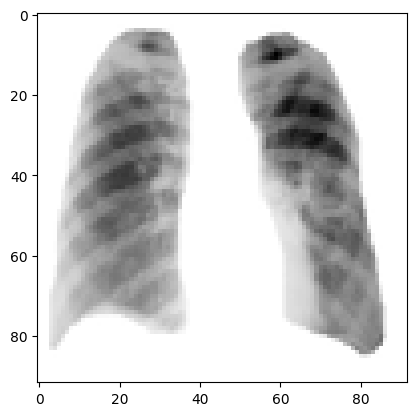

In [15]:
sample_batched['image'][0]
imagen = sample_batched['image'][0]
imagen = np.squeeze(imagen)
# Muestra la imagen en escala de grises
plt.imshow(imagen,cmap='gray')
plt.show()

**DistributedTraining.py**

In [16]:
def loss_batch(loss_func, xb, yb, yb_h, opt=None):
    # Obtain the loss
    size_yh = yb_h.size()
    size_y = yb.size()
    # print(size_yh)
    # print(size_y)
    loss = loss_func(yb_h, yb)
    # Obtain peformance metric
    metric_b = metrics_batch(yb, yb_h)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), metric_b
    # return metric_b

# Helper function to compute the accuracy per mini_batch


def metrics_batch(target, output):
    # Obtain output class
    pred = output.argmax(dim=1, keepdim=True)
    # Compare output class with target class
    corrects = pred.eq(target.view_as(pred)).sum().item()

    return corrects

# Helper function to compute the loss and metric values for a dataset


def loss_epoch(device, model, loss_func, dataset_dl, opt=None):
    loss = 0.0
    metric = 0.0
    len_data = len(dataset_dl.dataset)
    for i, data in enumerate(dataset_dl, 0):
        # print('batch: ', i)
        xb, yb = data['image'], data['label']
        xb = xb.type(torch.double).to(device, dtype=torch.float32)
        yb = yb.to(device, dtype=torch.long)

        # Obtain model output
        yb_h = model(xb)

        loss_b, metric_b = loss_batch(loss_func, xb, yb, yb_h, opt)
        loss += loss_b
        if metric_b is not None:
            metric += metric_b

    loss /= len_data
    metric /= len_data

    return loss, metric
    # return metric

# Define the training function


def train_val(device, epochs, model, opt, loss_func, train_dl, test_dl):

    for epoch in range(epochs):
        # print(epoch)
        model.train()
        train_loss, train_metric = loss_epoch(
            device, model, loss_func, train_dl, opt)
        # train_metric = loss_epoch(model, loss_func, train_dl, opt)
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(
                device, model, loss_func, test_dl)
            # val_metric = loss_epoch(model, loss_func, test_dl)
        accuracy = val_metric

        # print("Epoch: %d, train loss: %.6f, val loss: %.6f, test accuracy: %.2f" %(epoch, train_loss, val_loss, accuracy))

    return accuracy, model


def training(num, device, model, n_epochs, loss_func, train_dl, test_dl, lr, w, max_params):
    # Number of parameters
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    model.to(device)

    # Optimizer
    opt = optim.Adam(model.parameters(), lr=lr)

    # Obtaining training accuracy
    accuracy, _ = train_val(device, n_epochs, model, opt,
                            loss_func, train_dl, test_dl)

    # Fitness function based on accuracy and No. of parameters
    # f = abs(accuracy - w*(1 - abs((max_params - params)/max_params)))
    f = (1 - w)*accuracy + w*((max_params - params)/max_params)
    '''if params < max_params:
        f = (1 - w)*accuracy + abs(w*((max_params - params)/max_params))'''
    '''else:
        #f = (1 - w)*accuracy - abs(w*((max_params - params)/max_params))
        f = accuracy - abs((max_params - params)/max_params)'''

    # Append results to multiprocessing list
    # acc_list.append([num, f, accuracy, params])
    return num, f, accuracy, params

**Loading GPU**

In [17]:
print(torch.cuda.cudaStatus.ERROR_NOT_READY)
if torch.cuda.is_available():
  device1 = torch.device("cuda:0")
  # device1 = torch.device("cpu")
  print(device1)

34
cuda:0


**DeepGA**

In [18]:
#Maximun and minimum numbers of layers to initialize networks
min_conv = 2
max_conv = 6
min_full = 1
max_full = 6

'''Genetic Algorithm Parameters'''
cr = 0.7 #Crossover rate
mr = 0.5 #Mutation rate
N = 20 #Population size
T = 50 #Number of generations
t_size = 6 #tournament size
w = 0.3 #penalization weight
max_params = 3e6
num_epochs = 5 # TODO: retrunt to 50
lr = 1e-3
# loss_func = nn.NLLLoss(reduction = "sum")
# loss_func = nn.NLLLoss()
loss_func = nn.CrossEntropyLoss()

In [19]:
import timeit
import pickle
import pandas as pd
from multiprocessing import Process, Manager
from torchsummary import summary

'''Initialize population'''
print('Initialize population')

# train_dl, test_dl = loading_data()

start = timeit.default_timer()
pop = []
bestAcc = []
bestF = []
bestParams = []
# manager = Manager()
while len(pop) < N:
    # acc_list = manager.list()

    # Creating genomes (genetic encoding)
    e1 = Encoding(min_conv, max_conv, min_full, max_full)
    # e2 = Encoding(min_conv,max_conv,min_full,max_full)

    # Decoding the networks
    network1 = decoding(e1)
    # network2 = decoding(e2)
    # print(network1)

    # Creating the CNNs
    # print(network1[2])
    cnn1 = CNN(e1, network1[0], network1[1], network1[2])
    # cnn2 = CNN(e2, network2[0], network2[1], network2[2])
    # Evaluate individuals
    num1, f1, accuracy1, params1 = training('1', device1, cnn1, num_epochs, loss_func,
                                            train_dl, test_dl, lr, w, max_params)

    # training2 = Process(target = training, args = ('2', device2, cnn2, num_epochs, loss_func,
    #                                              train_dl, test_dl, lr, w, max_params, acc_list))

    # training1.start()
    # training2.start()
    # training1.join()
    # training2.join()

    # if acc_list[0][0] == '1':
    pop.append([e1, f1, accuracy1, params1])
    # pop.append([e2, acc_list[1][1], acc_list[1][2], acc_list[1][3]])
    # else:
    # pop.append([e2, acc_list[0][1], acc_list[0][2], acc_list[0][3]])
    # pop.append([e1, acc_list[1][1], acc_list[1][2], acc_list[1][3]])

'''Genetic Algorithm'''
for t in range(T):
    print('Generation: ', t)

    # Parents Selection
    parents = []
    while len(parents) < int(N/2):
        # Tournament Selection
        tournament = random.sample(pop, t_size)
        p1 = selection(tournament, 'max')
        tournament = random.sample(pop, t_size)
        p2 = selection(tournament, 'max')
        while p1 == p2:
            tournament = random.sample(pop, t_size)
            p2 = selection(tournament, 'max')

        parents.append(p1)
        parents.append(p2)

    # Reproduction
    offspring = []
    while len(offspring) < int(N/2):
        par = random.sample(parents, 2)
        # Crossover + Mutation
        if cr >= random.uniform(0, 1):  # Crossover
            p1 = par[0][0]
            p2 = par[1][0]
            c1, c2 = crossover(p1, p2)

            # Mutation
            if mr >= random.uniform(0, 1):
                mutation(c1)

            if mr >= random.uniform(0, 1):
                mutation(c2)

            # Evaluate offspring
            # acc_list = manager.list()

            # Decoding the network
            network1 = decoding(c1)
            network2 = decoding(c2)

            # Creating the CNN
            cnn1 = CNN(c1, network1[0], network1[1], network1[2])
            cnn2 = CNN(c2, network2[0], network2[1], network2[2])

            # Evaluate individuals
            num_cnn1, f_cnn1, accuracy_cnn1, params_cnn1 = training('1', device1, cnn1, num_epochs, loss_func,
                                                                    train_dl, test_dl, lr, w, max_params)
            offspring.append([c1, f_cnn1, accuracy_cnn1, params_cnn1])

            num_cnn2, f_cnn2, accuracy_cnn2, params_cnn2 = training('2', device1, cnn2, num_epochs, loss_func,
                                                                    train_dl, test_dl, lr, w, max_params)
            offspring.append([c2, f_cnn2, accuracy_cnn2, params_cnn2])

    # Replacement with elitism
    pop = pop + offspring
    pop.sort(reverse=True, key=lambda x: x[1])
    pop = pop[:N]

    leader = max(pop, key=lambda x: x[1])
    bestAcc.append(leader[2])
    bestF.append(leader[1])
    bestParams.append(leader[3])

    print('Best fitness: ', leader[1])
    print('Best accuracy: ', leader[2])
    print('Best No. of Params: ', leader[3])
    print('No. of Conv. Layers: ', leader[0].n_conv)
    print('No. of FC Layers: ', leader[0].n_full)
    print('--------------------------------------------')

results = pd.DataFrame(list(zip(bestAcc, bestF, bestParams)), columns=[
                       'Accuracy', 'Fitness', 'No. Params'])
final_networks = []
final_connections = []
objects = []
for member in pop:
    p = member[0]
    objects.append(p)
    n_conv = p.n_conv
    n_full = p.n_full
    description = 'The network has ' + \
        str(n_conv) + ' convolutional layers ' + 'with: '
    for i in range(n_conv):
        nfilters = str(p.first_level[i]['nfilters'])
        fsize = str(p.first_level[i]['fsize'])
        pool = str(p.first_level[i]['pool'])
        psize = str(p.first_level[i]['psize'])
        layer = '(' + nfilters + ', ' + fsize + \
            ', ' + pool + ', ' + psize + ') '
        description += layer
    description += 'and '
    description += str(n_full)
    description += ' '
    description += 'fully-connected layers with: '
    for i in range(n_conv, n_conv+n_full):
        neurons = str(p.first_level[i]['neurons'])
        layer = '(' + neurons + ')'
        description += layer
    description += ' neurons'
    final_networks.append(description)

    connections = ''
    for bit in p.second_level:
        if bit == 1:
            connections += 'one - '
        if bit == 0:
            connections += 'zero - '
    final_connections.append(connections)


final_population = pd.DataFrame(list(zip(final_networks, final_connections)), columns=[
                                'Network Architecture', 'Connections'])

'''Saving Results as CSV'''
final_population.to_csv('final_population.csv', index=False)
results.to_csv('results.csv', index=False)
stop = timeit.default_timer()
execution_time = (stop-start)/3600
print("Execution time: ", execution_time)

# Saving objects

with open('cnns.pkl', 'wb') as output:
    pickle.dump(objects, output, pickle.HIGHEST_PROTOCOL)
    output.close()

Initialize population


/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


RuntimeError: Given input size: (16x4x4). Calculated output size: (16x0x0). Output size is too small

In [ ]:
# !cp final_population.csv /content/gdrive/MyDrive/Ricardo

In [ ]:
# !cp result.csv /content/gdrive/MyDrive/Ricardo

In [ ]:
# !cp cnns.pkl /content/gdrive/MyDrive/Ricardo

In [ ]:
# from google.colab import files
# uploaded = files.upload()
# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [ ]:
import pickle
model = pickle.load(open("cnns.pkl", "rb"))

In [ ]:

final_networks = []
final_connections = []
objects = []
for member in output:
    p = member
    objects.append(p)
    n_conv = p.n_conv
    n_full = p.n_full
    description = 'The network has ' + str(n_conv) + ' convolutional layers ' + 'with: '
    for i in range(n_conv):
        nfilters = str(p.first_level[i]['nfilters'])
        fsize = str(p.first_level[i]['fsize'])
        pool = str(p.first_level[i]['pool'])
        psize = str(p.first_level[i]['psize'])
        layer = '(' + nfilters + ', ' + fsize + ', ' + pool + ', ' + psize + ') '
        description += layer
    description += 'and '
    description += str(n_full)
    description += ' '
    description += 'fully-connected layers with: '
    for i in range(n_conv, n_conv+n_full):
        neurons = str(p.first_level[i]['neurons'])
        layer = '(' + neurons + ')'
        description += layer
    description += ' neurons'
    final_networks.append(description)

    connections = ''
    for bit in p.second_level:
        if bit == 1:
            connections += 'one - '
        if bit == 0:
            connections += 'zero - '
    final_connections.append(connections)


#final_population = pd.DataFrame(list(zip(final_networks, final_connections)), columns = ['Network Architecture', 'Connections'])

'''Saving Results as CSV'''
#final_population.to_csv('final_population.csv', index = False)
#results.to_csv('results.csv', index = False)
#stop = timeit.default_timer()
#execution_time = (stop-start)/3600
#print("Execution time: ", execution_time)

ValueError: I/O operation on closed file.

In [ ]:
final_networks